In [282]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import pandas as pd
import numpy as np
import re
from scipy import sparse

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras import models
from keras import layers
from keras.utils.vis_utils import model_to_dot

from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble

from IPython.display import SVG

In [283]:
df_train = pd.read_csv('train.csv', encoding='utf8')
df_test = pd.read_csv('test.csv', encoding='utf8')

In [284]:
def parse_df(df):
    match_numbers = re.compile(r'[0-9]+', flags=re.IGNORECASE)
    df['comment_text'] = df.comment_text.str.replace(match_numbers, 'num')
    df['comment_text'] = df.comment_text.str.replace('[\n"]', ' ')
    
    df['comment_length'] = df['comment_text'].apply(lambda r: len(r.split(' ')))
    df['nb_unique_words'] = df['comment_text'].apply(lambda r: len(set(r.split(' '))))
    df['unique_words_ratio'] = df['nb_unique_words'] / df['comment_length'].astype(float)
    
    df['nb_!'] = df['comment_text'].apply(lambda r: r.count('!'))
    df['nb_uppercase'] = df['comment_text'].apply(lambda r: len(re.findall('[A-Z\d]+', r)))
    
    return df

In [285]:
df_train = parse_df(df_train)

In [322]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length,nb_unique_words,unique_words_ratio,nb_!,nb_uppercase
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,43,41,0.953488,0,14
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,18,18,1.000000,1,6
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42,39,0.928571,0,4
3,0001b41b1c6bb37e,More I can't make any real suggestions on im...,0,0,0,0,0,0,122,82,0.672131,0,11
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13,13,1.000000,0,2


# Feature Analysis

In [326]:
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
dfs = []

for col in cols:
    mean_for_col = df_train.loc[df_train[col] == 1][['comment_length', 'nb_unique_words',
                                                     'unique_words_ratio', 'nb_!', 'nb_uppercase']].mean()
    
    dfs.append(mean_for_col)

   comment_length  nb_unique_words  unique_words_ratio       nb_!  \
0       55.211259        32.328495            0.835806   3.631686   
1       80.346082        22.308464            0.788879  16.275862   
2       53.180968        29.820570            0.837579   3.330098   
3       58.029289        28.472803            0.813542  16.822176   
4       51.522788        29.144979            0.840939   3.731497   
5       55.431317        29.551601            0.834065   2.311744   

   nb_uppercase  
0     15.322741  
1     43.139812  
2     16.328560  
3     28.031381  
4     16.070077  
5     19.441281  


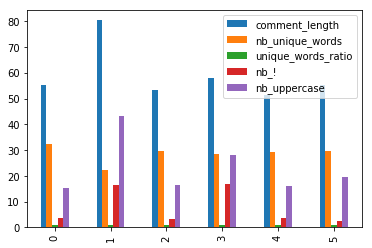

In [339]:
%matplotlib inline


print(pd.concat(dfs, axis=1).T)

pd.concat(dfs, axis=1).T.plot(kind='bar')

# Models

## Linear Model

In [173]:
v = TfidfVectorizer(ngram_range=(1, 2),
                    max_features=100000,
                    stop_words='english')

X = sparse.hstack([v.fit_transform(df_train['comment_text']),
                   StandardScaler().fit_transform(df_train['nb_unique_words'].values.reshape(-1, 1)),
                   StandardScaler().fit_transform(df_train['nb_!'].values.reshape(-1, 1)),
                   StandardScaler().fit_transform(df_train['unique_words_ratio'].values.reshape(-1, 1)),
                   StandardScaler().fit_transform(df_train['nb_uppercase'].values.reshape(-1, 1)),
                   StandardScaler().fit_transform(df_train['comment_length'].values.reshape(-1, 1)),
                  ])
y = df_train['toxic']

clf = linear_model.LogisticRegression()

np.mean(cross_val_score(clf, X, y, scoring='roc_auc'))

/home/eric/code/venvs/data3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.9689131599600443

## Gradient Boosting

In [168]:
v = TfidfVectorizer(ngram_range=(1, 1),
                    max_features=10000,
                    stop_words='english')

X = sparse.hstack([v.fit_transform(df_train['comment_text']),
                   # df_train['nb_unique_words'].values.reshape(-1, 1),
                   df_train['nb_!'].values.reshape(-1, 1),
                   df_train['unique_words_ratio'].values.reshape(-1, 1),
                   df_train['nb_uppercase'].values.reshape(-1, 1),
                   df_train['comment_length'].values.reshape(-1, 1),
                  ])
y = df_train['toxic']


clf = ensemble.GradientBoostingClassifier()

np.mean(cross_val_score(clf, X, y, scoring='roc_auc'))

0.911372003836853

## GRU

In [38]:
X = pad_sequences(df_train['comment_text'].head(10000).map(lambda r: one_hot(r, 100000)), maxlen=300)
y = df_train['toxic'].head(10000)

X_train, X_val, y_train, y_val = train_test_split(X, y)

In [39]:
model = Sequential()
model.add(Embedding(input_dim=100000,
                    output_dim=128,
                    input_shape=(300,)))
model.add(GRU(128))
model.add(Dropout(0.4))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [40]:
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=2)

Train on 7500 samples, validate on 2500 samples
Epoch 1/2
7500/7500 [==============================] - 60s 8ms/step - loss: 0.2558 - acc: 0.9187 - val_loss: 0.1761 - val_acc: 0.9392
Epoch 2/2
7500/7500 [==============================] - 59s 8ms/step - loss: 0.0984 - acc: 0.9641 - val_loss: 0.2142 - val_acc: 0.9280


In [41]:
roc_auc_score(model.predict_classes(X_val), y_val)

0.8142222222222223

## Mixing Inputs

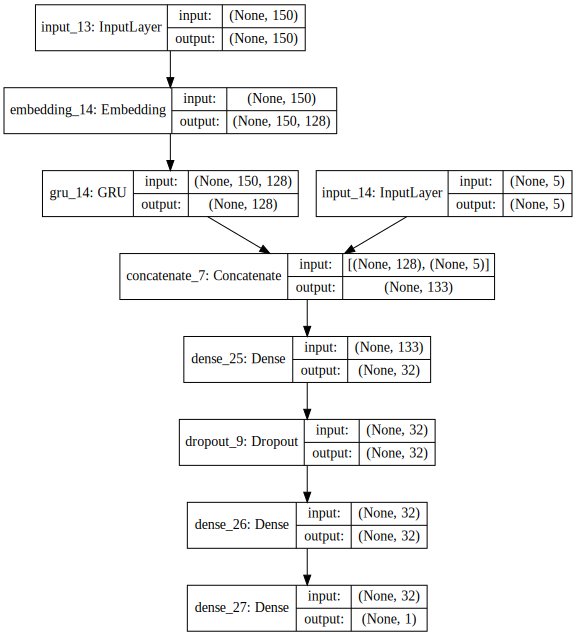

In [202]:
i_text = layers.Input(shape=(150,), dtype='int32')

e_text = layers.Embedding(input_dim=100000,
                          output_dim=128,
                          input_shape=(150,))(i_text)

gru_text = layers.GRU(128)(e_text)

i_numerical = layers.Input(shape=(5,), dtype='float32')

c = layers.concatenate([gru_text, i_numerical])
h = layers.Dense(32, activation='relu')(c)
h = layers.Dropout(0.3)(h)
h = layers.Dense(32, activation='relu')(h)
o = layers.Dense(1, activation='sigmoid')(h)

model = models.Model(inputs=[i_text, i_numerical],
                     outputs=[o])

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [204]:
df = df_train.sample(frac=1)
print(len(df))
train, val = train_test_split(df)

def parse_df_2(df):
    x_text = pad_sequences(df['comment_text'].map(lambda r: one_hot(r, 100000)), maxlen=150)

    x_numerical = np.hstack([df['nb_unique_words'].values.reshape(-1, 1),
                             df['nb_!'].values.reshape(-1, 1),
                             df['unique_words_ratio'].values.reshape(-1, 1),
                             df['nb_uppercase'].values.reshape(-1, 1),
                             df['comment_length'].values.reshape(-1, 1),])
    
    return [x_text, x_numerical]

model.fit(parse_df_2(train),
          train['toxic'],
          epochs=2)

159571
Epoch 1/2
119678/119678 [==============================] - 719s 6ms/step - loss: 0.1690 - acc: 0.9459
Epoch 2/2
119678/119678 [==============================] - 668s 6ms/step - loss: 0.1041 - acc: 0.9640


In [205]:
roc_auc_score(list(map(lambda r: 1 if r > 0.5 else 0, model.predict(parse_df_2(val)))),
              val['toxic'])

0.9175305551898955

## Pre trained embeddings

In [289]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=50000)
tokenizer.fit_on_texts(df_train['comment_text'])
sequences = tokenizer.texts_to_sequences(df_train['comment_text'])

word_index = tokenizer.word_index
print('Found {0} unique tokens.'.format(len(word_index)))

data = pad_sequences(sequences, maxlen=150)

/home/eric/code/venvs/data3/lib/python3.5/site-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 199997 unique tokens.


In [290]:
embeddings_index = {}

f = open(os.path.join('/home/eric/data', 'glove.42B.300d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    if word in word_index:
        embeddings_index[word] = coefs

f.close()

print('Found {0} word vectors.'.format(len(embeddings_index)))

Found 119720 word vectors.


In [292]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [293]:
from keras.layers import Embedding

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=150,
                            trainable=False)

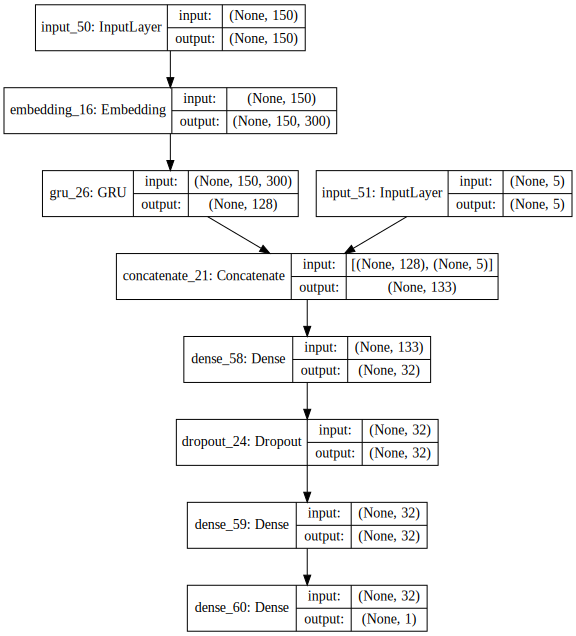

In [297]:
sequence_input = layers.Input(shape=(150,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
gru_sequences = layers.GRU(128)(embedded_sequences)

numerical_input = layers.Input(shape=(5,), dtype='float32')

c = layers.concatenate([gru_sequences, numerical_input])
h = layers.Dropout(0.3)(h)
h = layers.Dense(32, activation='relu')(c)
h = layers.Dropout(0.3)(h)
h = layers.Dense(32, activation='relu')(h)
preds = layers.Dense(1, activation='sigmoid')(h)

model = models.Model(inputs=[sequence_input, numerical_input],
                     outputs=[preds])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [295]:
X_sequence = np.asarray(data)
X_numerical = np.hstack([df_train['nb_unique_words'].values.reshape(-1, 1),
                         df_train['nb_!'].values.reshape(-1, 1),
                         df_train['unique_words_ratio'].values.reshape(-1, 1),
                         df_train['nb_uppercase'].values.reshape(-1, 1),
                         df_train['comment_length'].values.reshape(-1, 1),])
labels = df_train['toxic']

In [298]:
from sklearn.cross_validation import StratifiedKFold

skf = StratifiedKFold(labels, n_folds=3, shuffle=True)

for i, (train_indices, val_indices) in enumerate(skf):
    model.fit([X_sequence[train_indices], X_numerical[train_indices]],
              labels[train_indices],
              validation_data=([X_sequence[val_indices], X_numerical[val_indices]], labels[val_indices]),
              epochs=2,
              batch_size=128)
    
    print(roc_auc_score(list(map(lambda r: 1 if r > 0.5 else 0, model.predict([X_sequence[val_indices], X_numerical[val_indices]]))),
                        labels[val_indices]))
    break

Train on 106380 samples, validate on 53191 samples
Epoch 1/2
106380/106380 [==============================] - 271s 3ms/step - loss: 0.1923 - acc: 0.9429 - val_loss: 0.1072 - val_acc: 0.9620
Epoch 2/2
106380/106380 [==============================] - 264s 2ms/step - loss: 0.1006 - acc: 0.9640 - val_loss: 0.0991 - val_acc: 0.9642
0.9258205029884012


In [314]:
results_df = pd.concat([pd.DataFrame.from_dict({'y_pred_proba': model.predict([X_sequence[:400], X_numerical[:400]]).reshape(-1,),
                                                'y_true': labels[:400]}),
                        df_train[['comment_text', 'comment_length', 'nb_unique_words',
                                  'unique_words_ratio', 'nb_!', 'nb_uppercase']].head(400)],
                       axis=1)

results_df['y_pred'] = results_df['y_pred_proba'].apply(lambda r: 1 if r > 0.5 else 0)
results_df.head()

,y_pred_proba,y_true,comment_text,comment_length,nb_unique_words,unique_words_ratio,nb_!,nb_uppercase,y_pred
0,0.015398,0,Explanation Why the edits made under my userna...,43,41,0.953488,0,14,0
1,0.000800,0,D'aww! He matches this background colour I'm s...,18,18,1.000000,1,6,0
2,0.008016,0,"Hey man, I'm really not trying to edit war. It...",42,39,0.928571,0,4,0
3,0.000138,0,More I can't make any real suggestions on im...,122,82,0.672131,0,11,0
4,0.089662,0,"You, sir, are my hero. Any chance you remember...",13,13,1.000000,0,2,0


In [317]:
results_df.loc[results_df.y_true != results_df.y_pred].sort_values(by='y_pred_proba', ascending=False).head(100)

,y_pred_proba,y_true,comment_text,comment_length,nb_unique_words,unique_words_ratio,nb_!,nb_uppercase,y_pred
368,0.823535,0,hate is my topic is hate if you hate a person ...,23,18,0.782609,0,1,1
61,0.746426,0,"A Bisexual, like a homosexual or a heterosexua...",55,39,0.709091,0,4,1
179,0.614984,0,"REPLY ABOVE: That was me, loser. The UN define...",132,100,0.757576,0,31,1
175,0.574246,0,know the sex of the foetus,10,6,0.600000,0,0,1
183,0.520552,0,== new == {{userbox TABTAB| id = TABTAB...,70,32,0.457143,0,19,1
278,0.494726,1,Hey why you are spreading misconceptions and t...,38,30,0.789474,0,4,0
16,0.490767,1,"Bye! Don't look, come or think of comming ba...",12,11,0.916667,2,3,0
300,0.372322,1,"Well you are ridiculous, in fact I suspect tha...",18,15,0.833333,0,4,0
59,0.361875,1,Why can't you believe how fat Artie is? Did yo...,76,61,0.802632,5,18,0
206,0.315800,1,Give me a permanat block raseac....!!! remembe...,106,81,0.764151,6,4,0
